In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from urllib import parse

np.set_printoptions(threshold=sys.maxsize)

In [20]:
tweets = pd.read_csv("dataset/train.csv")

**Оценка данных**

На первом этапе посмотрим состав данных. Каков их размер, сбалансирована выборка или нет, какие ключевые слова имеем. Рассмотрим длину предложений в зависимости от цели.

In [21]:
tweets.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [22]:
tweets.shape

(7613, 5)

In [23]:
tweets.target.value_counts(normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

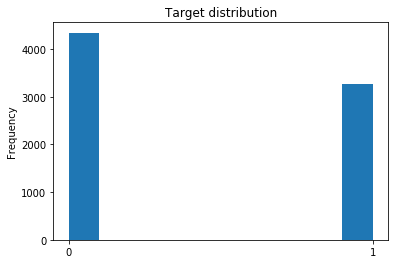

In [24]:
tweets.target.plot(y='Frequancy', kind='hist',  title='Target distribution', xticks=[0,1])
plt.show()

//---------- Далее нмного почистим текст, ключевые слова и локации ----------//


In [301]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].replace(np.nan, '', regex=True)
    df[text_field] = df[text_field].apply(lambda x: parse.unquote(x))
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.lower()
    return df

tweets = standardize_text(tweets, "text")
tweets = standardize_text(tweets, "keyword")
tweets = standardize_text(tweets, "location")

tweets['tokens'] = tweets['text'].apply(lambda x: my_analyzer(x))

tweets.to_csv("dataset/clean_train.csv")

tweets.head()

,id,keyword,location,text,target,text_len,text_punct,tokens
3190,4579,emergency plan,north hastings ontario,practice your families fire escape plan so eve...,0,76,0.0,"[practice, family, fire, escape, plan, everyon..."
6171,8801,sirens,"nomad, usa",fuck sleeping with sirens,0,22,0.0,"[fuck, sleeping, siren, ]"
1196,1722,buildings burning,,'i'm a gemini' children screaming buildings b...,1,70,4.3,"[im, gemini, child, screaming, building, burni..."
680,982,blazing,"pig symbol, alabama",montgomery come for the blazing hot weather ...,1,79,0.0,"[montgomery, come, blazing, hot, weather, stay..."
3358,4808,evacuated,,i got evacuated from the cinema 30 mins throug...,0,61,0.0,"[got, evacuated, cinema, 30, min, inside, kill..."


In [26]:
keywords = pd.DataFrame({"name":tweets.keyword.value_counts(normalize=True).index.tolist(),
             "weight":tweets.keyword.value_counts(normalize=True).tolist()})
keywords.sort_values(['weight'], ascending=False)

,name,weight
0,,0.008013
1,fatalities,0.005911
2,deluge,0.005517
3,armageddon,0.005517
4,sinking,0.005386
...,...,...
217,forest fire,0.002496
218,epicentre,0.001576
219,threat,0.001445
220,inundation,0.001314


In [27]:
locations = pd.DataFrame({"name":tweets.location.value_counts(normalize=True).index.tolist(),
             "weight":tweets.location.value_counts(normalize=True).tolist()})
locations.sort_values(['weight'], ascending=False)

,name,weight
0,,0.333114
1,usa,0.013661
2,new york,0.009852
3,united states,0.006568
4,london,0.006436
...,...,...
1430,punpunl ndia,0.000131
1431,"wilbraham, ma",0.000131
1432,cedar rapids ia,0.000131
1433,"birdland, new meridian, fd",0.000131


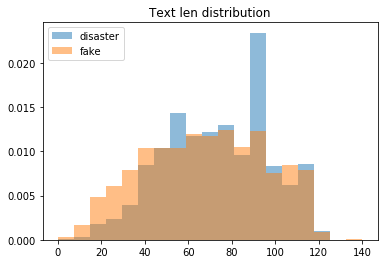

In [29]:
tweets['text_len'] = tweets['text'].apply(lambda x: len(x) - x.count(" "))

bins = np.linspace(0, 140, 20)
plt.hist(tweets[tweets['target']==1]['text_len'], bins, alpha=0.5, density=True, label='disaster')
plt.hist(tweets[tweets['target']==0]['text_len'], bins, alpha=0.5, density=True, label='fake')
plt.legend(loc='upper left')
plt.title('Text len distribution')
plt.show()

In [30]:
import string

def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

tweets['text_punct'] = tweets['text'].apply(lambda x: count_punct(x))

tweets.head()

,id,keyword,location,text,target,text_len,text_punct
0,1,,,our deeds are the reason of this earthquake m...,1,56,0.0
1,4,,,forest fire near la ronge sask canada,1,31,0.0
2,5,,,all residents asked to 'shelter in place' are ...,1,111,1.8
3,6,,,"13,000 people receive wildfires evacuation or...",1,56,1.8
4,7,,,just got sent this photo from ruby alaska as ...,1,70,0.0


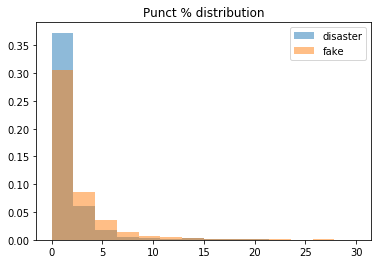

In [31]:
bins = np.linspace(0, 30, 15)
plt.hist(tweets[tweets['target']==1]['text_punct'], bins, alpha=0.5, density=True, label='disaster')
plt.hist(tweets[tweets['target']==0]['text_punct'], bins, alpha=0.5, density=True, label='fake')
plt.legend(loc='upper right')
plt.title('Punct % distribution')
plt.show()

// ------- Перемешаем данные ----- //

In [32]:
from sklearn.utils import shuffle

tweets = shuffle(tweets, random_state=2)

**Токенизируем. TFIDF Bag of Words**

In [140]:
import analyzeData
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

my_analyzer = analyzeData.ClearUpAnalyzer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kayash/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/kayash/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Для начала разобьем текст на тестовую и обучающую выборку

In [141]:
list_text = tweets["text"].tolist()
list_labels = tweets["target"].tolist()

X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(list_text, list_labels, test_size=0.3, 
                                                                                random_state=40)

In [224]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer(tokenizer=my_analyzer)

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_text_train_tfidf, tfidf_vectorizer = tfidf(X_text_train)
X_text_test_tfidf = tfidf_vectorizer.transform(X_text_test)

In [225]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=mcolors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Fake')
            green_patch = mpatches.Patch(color='blue', label='Disaster')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})

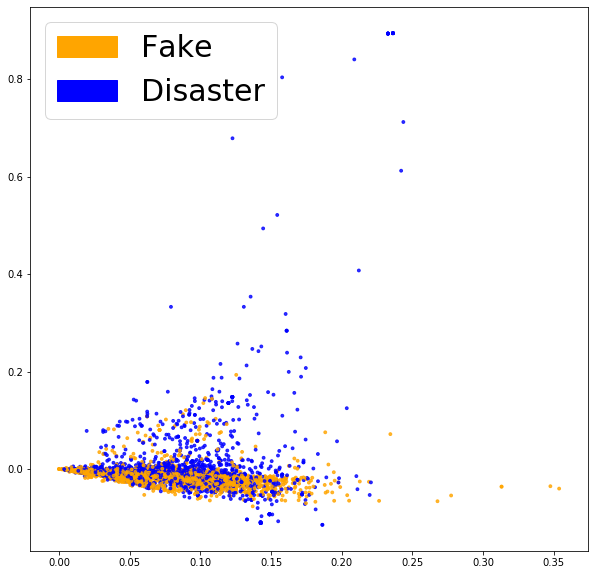

In [226]:
fig = plt.figure(figsize=(10, 10))          
plot_LSA(X_text_train_tfidf, y_text_train)
plt.show()

In [227]:
clf_tfidf = LogisticRegression(solver='newton-cg', random_state=2)
clf_tfidf.fit(X_text_train_tfidf, y_text_train)

y_predicted_tfidf = clf_tfidf.predict(X_text_test_tfidf)

In [228]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_text_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf))

accuracy = 0.811, precision = 0.814, recall = 0.811, f1 = 0.808


// ----- Исследуем полученные результаты ----- //

Confusion matrix, without normalization
[[1170  134]
 [ 297  683]]
Normalized confusion matrix
[[0.89723926 0.10276074]
 [0.30306122 0.69693878]]


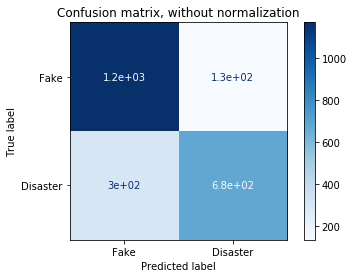

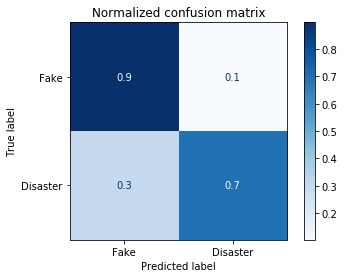

In [298]:
from sklearn.metrics import confusion_matrix,  plot_confusion_matrix

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

classes=['Fake','Disaster']
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_tfidf, X_text_test_tfidf, y_text_test,
                                 display_labels=classes,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

In [230]:
y_text_test.count(0), y_text_test.count(1)

(1304, 980)

 // ----- Определим самые важные признаки ----- //

In [231]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance_tgidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 15)

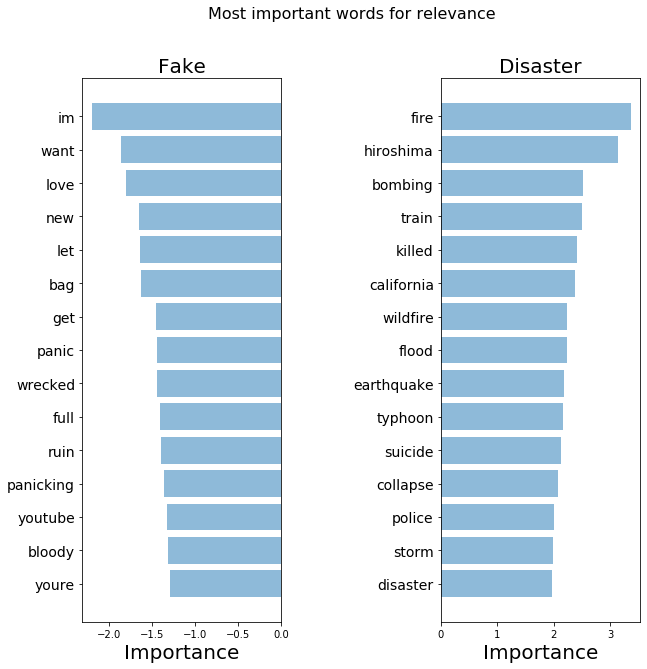

In [232]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Fake', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Disaster', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance_tgidf[0]['tops']]
top_words = [a[1] for a in importance_tgidf[0]['tops']]
bottom_scores = [a[0] for a in importance_tgidf[0]['bottom']]
bottom_words = [a[1] for a in importance_tgidf[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

**TFIDF N-GRAM**

In [293]:
def tfidf_ngram(data):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 4), tokenizer=my_analyzer)

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_text_train_tfidf_ngram, tfidf_vectorizer_ngram = tfidf_ngram(X_text_train)
X_text_test_tfidf_ngram = tfidf_vectorizer_ngram.transform(X_text_test)

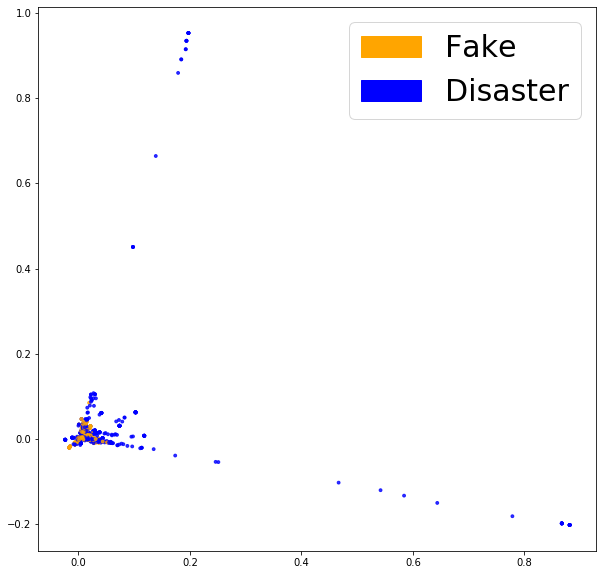

In [294]:
fig = plt.figure(figsize=(10, 10))          
plot_LSA(X_text_train_tfidf_ngram, y_text_train)
plt.show()

In [326]:
clf_tfidf_ngram = LogisticRegression(solver='newton-cg', random_state=2)
clf_tfidf_ngram.fit(X_text_train_tfidf_ngram, y_text_train)

y_predicted_tfidf_ngram = clf_tfidf_ngram.predict(X_text_test_tfidf_ngram)

In [296]:
accuracy_tfidf_ngram, precision_tfidf_ngram, recall_tfidf_ngram, f1_tfidf_ngram = get_metrics(y_text_test, y_predicted_tfidf_ngram)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf_ngram, precision_tfidf_ngram, recall_tfidf_ngram, f1_tfidf_ngram))

accuracy = 0.807, precision = 0.814, recall = 0.807, f1 = 0.802


Confusion matrix, without normalization
[[1194  110]
 [ 331  649]]
Normalized confusion matrix
[[0.91564417 0.08435583]
 [0.3377551  0.6622449 ]]


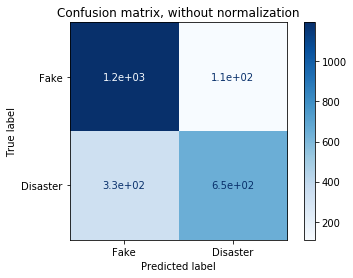

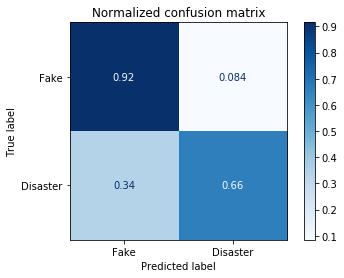

In [299]:
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_tfidf_ngram, X_text_test_tfidf_ngram, y_text_test,
                                 display_labels=classes,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

In [283]:
importance_tgidf_ngram = get_most_important_features(tfidf_vectorizer_ngram, clf_tfidf_ngram, 15)

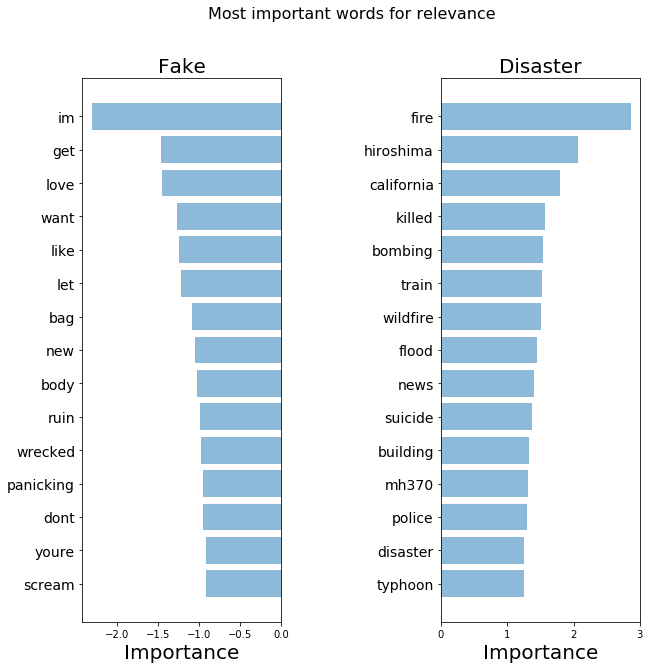

In [284]:
top_scores_ngram = [a[0] for a in importance_tgidf_ngram[0]['tops']]
top_words_ngram = [a[1] for a in importance_tgidf_ngram[0]['tops']]
bottom_scores_ngram = [a[0] for a in importance_tgidf_ngram[0]['bottom']]
bottom_words_ngram = [a[1] for a in importance_tgidf_ngram[0]['bottom']]

plot_important_words(top_scores_ngram, top_words_ngram, bottom_scores_ngram, bottom_words_ngram, "Most important words for relevance")

**Word Embedding и Word2Vec**

In [308]:
import nltk
from nltk.corpus import abc
import gensim

nltk.download('abc')
nltk.download('punkt')

[nltk_data] Downloading package abc to /Users/kayash/nltk_data...
[nltk_data]   Package abc is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kayash/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

// ------ Тут я тестирую то, что в презентации по BI было предложено ------ //

In [314]:
model= gensim.models.Word2Vec(abc.sents())

X = list(model.wv.vocab)

data=model.wv.most_similar('science')

In [315]:
len(X)

10363

// ----- Конец тестов, начало нормальной работы ------ //

In [317]:
word2vec_path = "dataset/GoogleNews-vectors-negative300.bin" 
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True) # скачала набор слов

In [329]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, tweets, generate_missing=False):
    embeddings = tweets['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [330]:
embeddings = get_word2vec_embeddings(word2vec, tweets)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels, 
                                                                                        test_size=0.3, random_state=40)

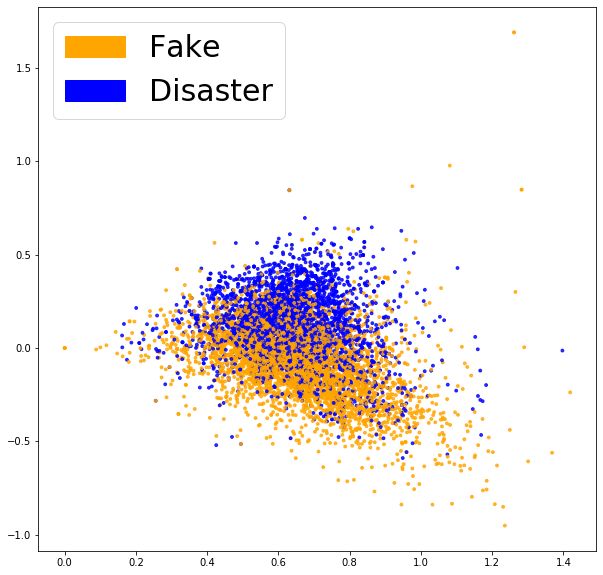

In [331]:
fig = plt.figure(figsize=(10, 10))          
plot_LSA(embeddings, list_labels)
plt.show()

In [332]:
clf_w2v = LogisticRegression(solver='newton-cg', random_state=2)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

In [333]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.793, precision = 0.792, recall = 0.793, f1 = 0.791


Confusion matrix, without normalization
[[1112  192]
 [ 281  699]]
Normalized confusion matrix
[[0.85276074 0.14723926]
 [0.28673469 0.71326531]]


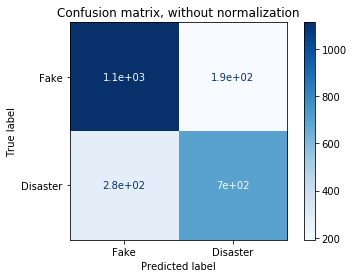

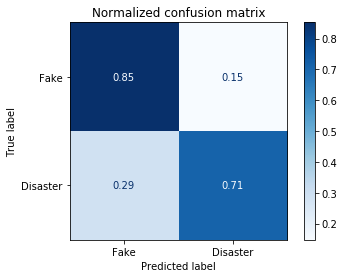

In [334]:
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_w2v, X_test_word2vec, y_text_test,
                                 display_labels=classes,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

// ----- Вписываю какой-то огромный кусок кода вместе с lime библиоткой для визуализации словечек -----//

In [342]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
from nltk.tokenize import RegexpTokenizer

In [343]:
vector_store = word2vec
def word2vec_pipeline(examples):
    global vector_store
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized_list = []
    for example in examples:
        example_tokens = tokenizer.tokenize(example)
        vectorized_example = get_average_word2vec(example_tokens, vector_store, generate_missing=False, k=300)
        tokenized_list.append(vectorized_example)
    return clf_w2v.predict_proba(tokenized_list)

c = make_pipeline(tfidf_vectorizer, clf_tfidf)

In [344]:
def explain_one_instance(instance, class_names):
    explainer = LimeTextExplainer(class_names=class_names)
    exp = explainer.explain_instance(instance, word2vec_pipeline, num_features=6)
    return exp

def visualize_one_exp(features, labels, index, class_names = ["irrelevant","relevant"]):
    exp = explain_one_instance(features[index], class_names = class_names)
    print('Index: %d' % index)
    print('True class: %s' % class_names[labels[index]])
    exp.show_in_notebook(text=True)

In [345]:
visualize_one_exp(X_text_test, y_text_test, 65)

Index: 65
True class: relevant


In [347]:
visualize_one_exp(X_text_test, y_text_test, 20)

Index: 20
True class: irrelevant


In [348]:
import random
from collections import defaultdict

random.seed(40)

In [349]:
def get_statistical_explanation(test_set, sample_size, word2vec_pipeline, label_dict):
    sample_sentences = random.sample(test_set, sample_size)
    explainer = LimeTextExplainer()
    
    labels_to_sentences = defaultdict(list)
    contributors = defaultdict(dict)
    
    # First, find contributing words to each class
    for sentence in sample_sentences:
        probabilities = word2vec_pipeline([sentence])
        curr_label = probabilities[0].argmax()
        labels_to_sentences[curr_label].append(sentence)
        exp = explainer.explain_instance(sentence, word2vec_pipeline, num_features=6, labels=[curr_label])
        listed_explanation = exp.as_list(label=curr_label)
        
        for word,contributing_weight in listed_explanation:
            if word in contributors[curr_label]:
                contributors[curr_label][word].append(contributing_weight)
            else:
                contributors[curr_label][word] = [contributing_weight]    
    
    # average each word's contribution to a class, and sort them by impact
    average_contributions = {}
    sorted_contributions = {}
    for label,lexica in contributors.items():
        curr_label = label
        curr_lexica = lexica
        average_contributions[curr_label] = pd.Series(index=curr_lexica.keys())
        for word,scores in curr_lexica.items():
            average_contributions[curr_label].loc[word] = np.sum(np.array(scores))/sample_size
        detractors = average_contributions[curr_label].sort_values()
        supporters = average_contributions[curr_label].sort_values(ascending=False)
        sorted_contributions[label_dict[curr_label]] = {
            'detractors':detractors,
             'supporters': supporters
        }
    return sorted_contributions

label_to_text = {
    0: 'Irrelevant',
    1: 'Relevant'
}
sorted_contributions = get_statistical_explanation(X_text_test, 100, word2vec_pipeline, label_to_text)

/Users/kayash/.conda/envs/big_data/lib/python3.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


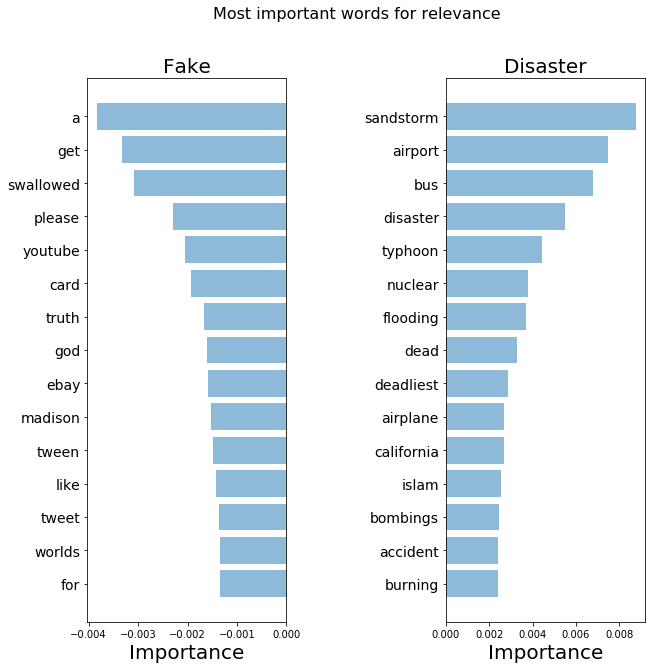

In [351]:
# First index is the class (Disaster)
# Second index is 0 for detractors, 1 for supporters
# Third is how many words we sample
top_words = sorted_contributions['Relevant']['supporters'][:15].index.tolist()
top_scores = sorted_contributions['Relevant']['supporters'][:15].tolist()
bottom_words = sorted_contributions['Relevant']['detractors'][:15].index.tolist()
bottom_scores = sorted_contributions['Relevant']['detractors'][:15].tolist()

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")